In [1]:
import pandas as pd
import quandl
import datetime

In [51]:
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2017,1,1)
end = datetime.date.today()

In [53]:
start

datetime.datetime(2017, 1, 1, 0, 0)

In [52]:
end

datetime.date(2018, 10, 27)

In [54]:
# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
s = "AAPL"
apple = quandl.get("WIKI/" + s, start_date=start, end_date=end)
 
type(apple)

pandas.core.frame.DataFrame

In [76]:
apple.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0


Populating the interactive namespace from numpy and matplotlib


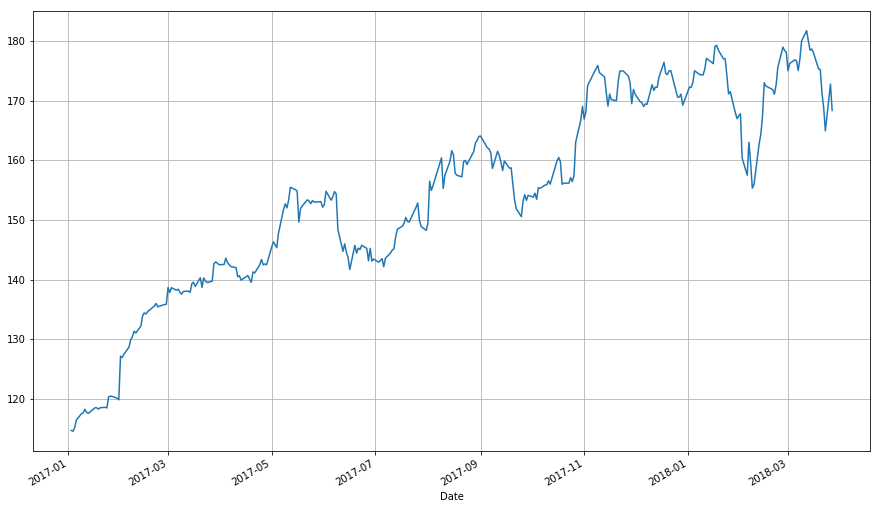

In [56]:
import matplotlib.pyplot as plt   # Import matplotlib

# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline

# Control the default size of figures in this Jupyter notebook
%pylab inline

# Change the size of plots
pylab.rcParams['figure.figsize'] = (15, 9)   
 
# Plot the adjusted closing price of AAPL
apple["Adj. Close"].plot(grid = True) 

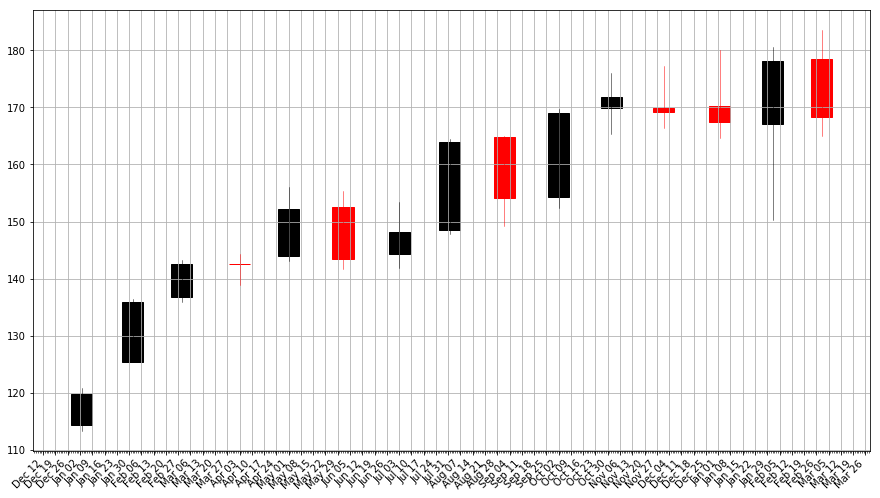

In [57]:
# Financial data is often plotted with a Japanese candlestick plot
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from mpl_finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", adj = False, otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param adj: A boolean indicating whether to use adjusted prices
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    fields = ["Open", "High", "Low", "Close"]
    if adj:
        fields = ["Adj. " + s for s in fields]
    transdat = dat.loc[:,fields]
    transdat.columns = pd.Index(["Open", "High", "Low", "Close"])
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple, adj=True, stick="month")


In [58]:
#get stock data for some other tech companies and plot their adjusted close together.

microsoft, google = (quandl.get("WIKI/" + s, start_date=start, end_date=end) for s in ["MSFT", "GOOG"])
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj. Close"],
                      "MSFT": microsoft["Adj. Close"],
                      "GOOG": google["Adj. Close"]})
 
stocks.head()

,AAPL,MSFT,GOOG
Date,,,
2017-01-03,114.715378,61.219142,786.14
2017-01-04,114.586983,60.945231,786.90
2017-01-05,115.169696,60.945231,794.02
2017-01-06,116.453639,61.473488,806.15
2017-01-09,117.520300,61.277837,806.65


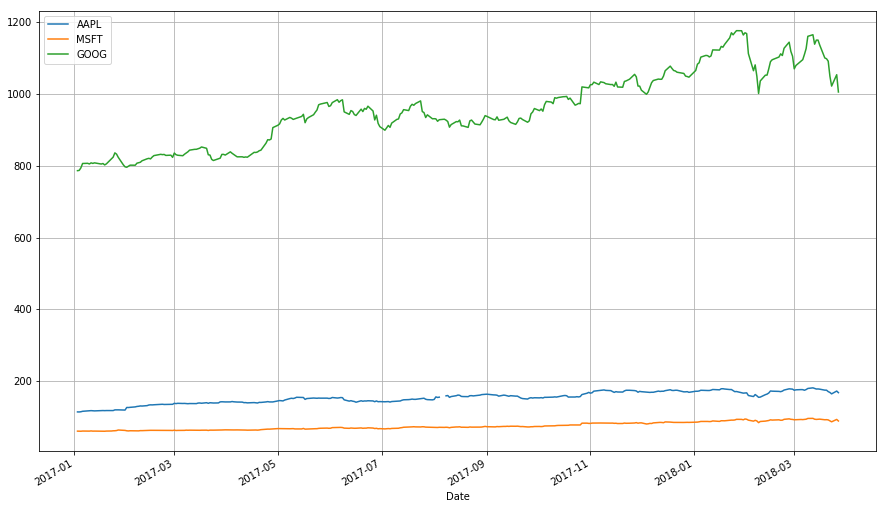

In [59]:
stocks.plot(grid = True)

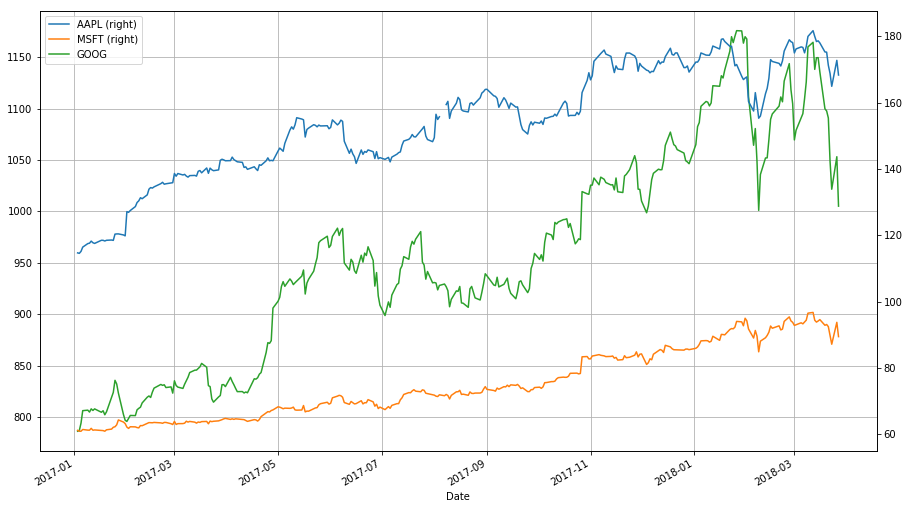

In [60]:
#use two different scales when plotting the data; 
#one scale will be used by Apple and Microsoft stocks (secondary_y axis on the right)
#and the other by Google (primary_y axis on the left)

stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

In [61]:
#using a lambda function
#which allows me to pass a small function defined quickly as a parameter to another function or method

In [62]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head() - 1

,AAPL,MSFT,GOOG
Date,,,
2017-01-03,0.000000,0.000000,0.000000
2017-01-04,-0.001119,-0.004474,0.000967
2017-01-05,0.003960,-0.004474,0.010024
2017-01-06,0.015153,0.004155,0.025453
2017-01-09,0.024451,0.000959,0.026090


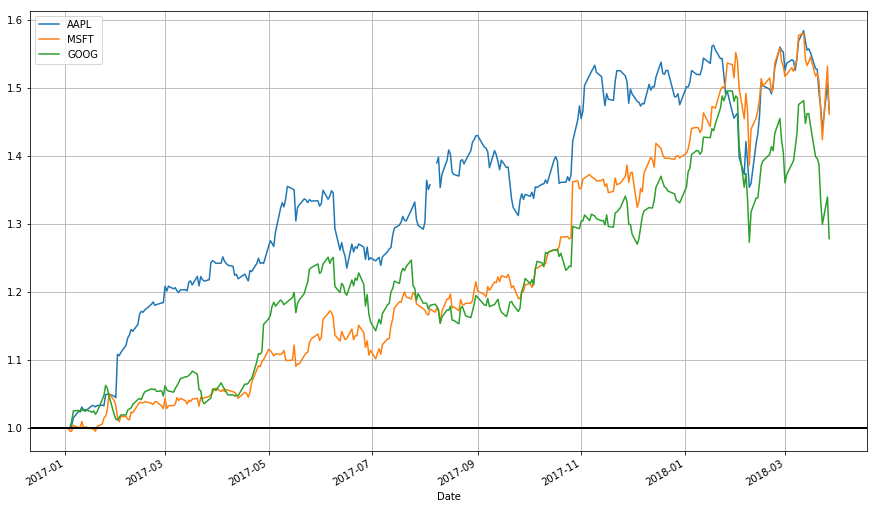

In [63]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

In [64]:
#This is a much more useful plot. 
#We can now see how profitable each stock was since the beginning of the period. 
#Furthermore, we see that these stocks are highly correlated; 
#they generally move in the same direction
#a fact that was difficult to see in the other charts.

In [65]:
#Log differences also more cleanly correspond to how stock prices are modeled in continuous time.

In [66]:
#obtain and plot the log differences of the data in stocks

# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) 
# shift moves dates back by 1.

stock_change.head()
stock_change.tail()

,AAPL,MSFT,GOOG
Date,,,
2018-03-21,-0.022915,-0.007004,-0.006241
2018-03-22,-0.014260,-0.029519,-0.039071
2018-03-23,-0.023399,-0.029499,-0.026573
2018-03-26,0.046379,0.072977,0.030502
2018-03-27,-0.025975,-0.047048,-0.046756


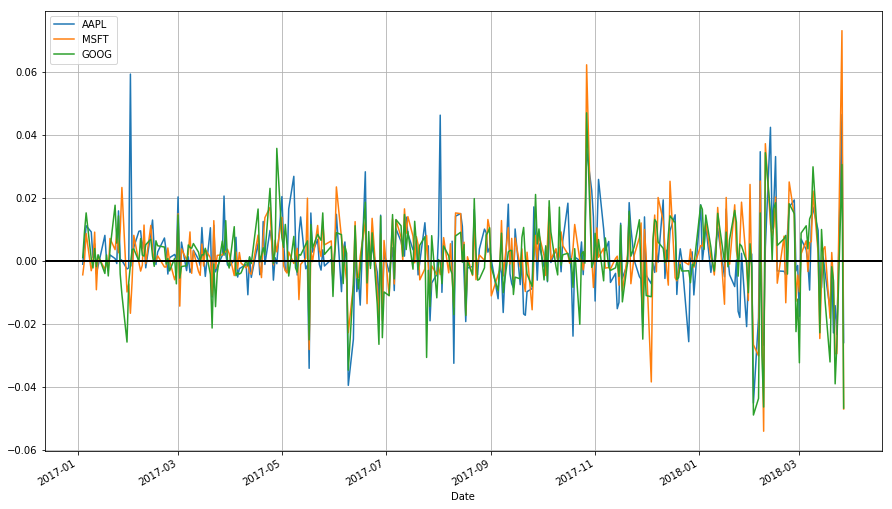

In [67]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

In [68]:
#SPY, which is the ticker symbol for the SPDR S&P 500 exchange-traded mutual fund (ETF), is a fund that attempts only to imitate the composition of the S&P 500 stock index, and thus represents the value in “the market.”

In [69]:
#read from a file

spyderdat = pd.read_csv("HistoricalQuotes.csv")    

                                                                        
spyderdat = pd.DataFrame(spyderdat.loc[:, ["open", "high", "low", "close", "close"]].iloc[1:].as_matrix(),
                         index=pd.DatetimeIndex(spyderdat.iloc[1:, 0]),
                         columns=["Open", "High", "Low", "Close", "Adj Close"]).sort_index()
 
spyder = spyderdat.loc[start:end]
 
stocks = stocks.join(spyder.loc[:, "Adj Close"]).rename(columns={"Adj Close": "SPY"})
stocks.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


,AAPL,MSFT,GOOG,SPY
Date,,,,
2017-01-03,114.715378,61.219142,786.14,225.24
2017-01-04,114.586983,60.945231,786.90,226.58
2017-01-05,115.169696,60.945231,794.02,226.40
2017-01-06,116.453639,61.473488,806.15,227.21
2017-01-09,117.520300,61.277837,806.65,226.46


In [70]:
spyder.head()

,Open,High,Low,Close,Adj Close
date,,,,,
2017-01-03,225.04,225.8300,223.8837,225.24,225.24
2017-01-04,225.62,226.7500,225.6100,226.58,226.58
2017-01-05,226.27,226.5800,225.4800,226.40,226.40
2017-01-06,226.53,227.7500,225.9000,227.21,227.21
2017-01-09,226.91,227.0701,226.4163,226.46,226.46


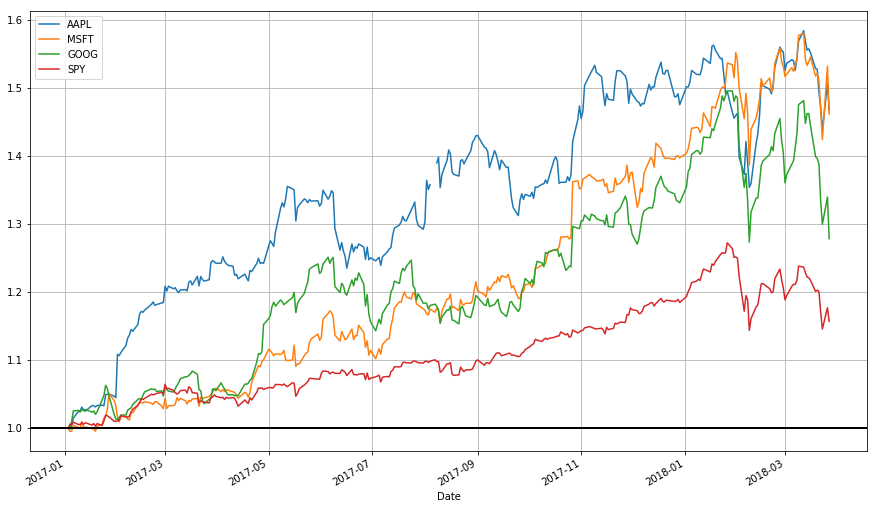

In [71]:
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)


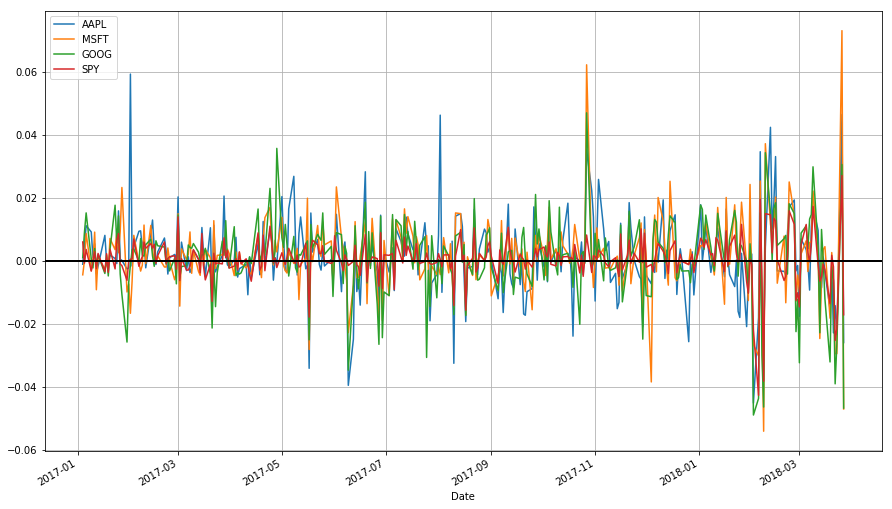

In [72]:
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1)))
stock_change.plot(grid=True).axhline(y = 0, color = "black", lw = 2)

In [73]:
#From what we have so far 
#we can already compute informative metrics for our stocks, 
#which can be considered some measure of risk.

In [74]:
#First, we will want to annualize our returns, 
#thus computing the annual percentage rate (APR). 
#This helps us keep returns on a common time scale.

In [79]:
stock_change_apr = stock_change * 252 * 100    
# There are 252 trading days in a year; 
#the 100 converts to percentages
stock_change_apr.tail()

,AAPL,MSFT,GOOG,SPY
Date,,,,
2018-03-21,-577.463148,-176.499833,-157.285338,-48.409635
2018-03-22,-359.355133,-743.873619,-984.592233,-637.937081
2018-03-23,-589.663945,-743.366326,-669.637836,-542.932908
2018-03-26,1168.762361,1839.012005,768.649993,680.185034
2018-03-27,-654.582257,-1185.615651,-1178.241231,-432.385872


In [82]:
#risk-free rate, which I denote by r_{RF}, is the rate of return on a risk-free financial asset
#This asset exists only in theory but often yields on low-risk instruments like 3-month U.S. 
#Treasury Bills can be viewed as being virtually risk-free and thus their yields can be used to approximate the risk-free rate. 

In [83]:
tbill = quandl.get("FRED/TB3MS", start_date=start, end_date=end)
tbill.tail()

,Value
Date,
2018-05-01,1.86
2018-06-01,1.90
2018-07-01,1.96
2018-08-01,2.03
2018-09-01,2.13


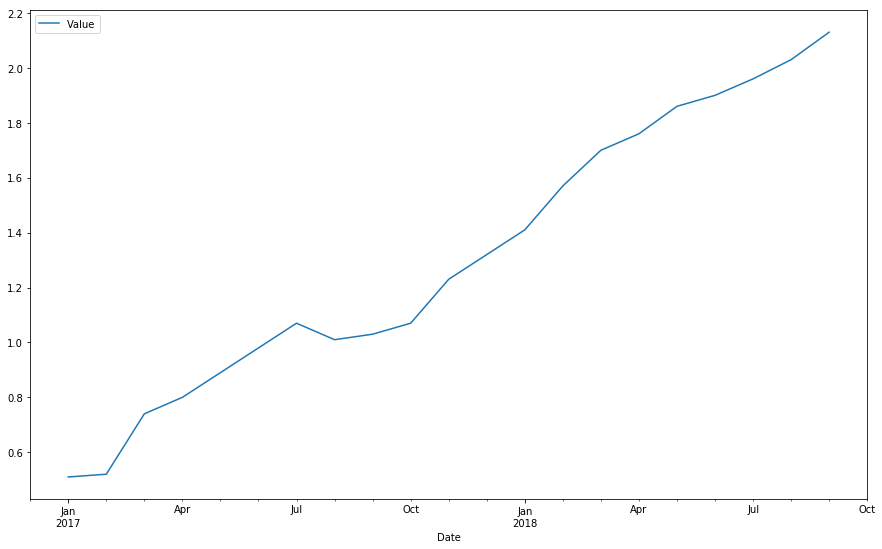

In [84]:
tbill.plot()

In [85]:
rrf = tbill.iloc[-1, 0]    
# Get the most recent Treasury Bill rate
rrf

2.13

In [86]:
#linear regression model
#Below I get a pandas Series that contains how much each stock is correlated with SPY (our approximation of the market).

In [87]:
smcorr = stock_change_apr.drop("SPY", 1).corrwith(stock_change_apr.SPY)    # Since RRF is constant it doesn't change the
                                                                           # correlation so we can ignore it in our
                                                                           # calculation
smcorr

AAPL    0.621166
MSFT    0.737923
GOOG    0.733031
dtype: float64

In [88]:
#Then I compute \alpha and \beta
#\alpha is average excess return over the market.
#\beta is how much a stock moves in relation to the market.

sy = stock_change_apr.drop("SPY", 1).std()
sx = stock_change_apr.SPY.std()
sy

AAPL    312.375699
MSFT    302.202353
GOOG    308.232965
dtype: float64

In [89]:
sx    # Standard deviation for x

170.4682751223667

In [90]:
ybar = stock_change_apr.drop("SPY", 1).mean() - rrf
xbar = stock_change_apr.SPY.mean() - rrf
ybar

AAPL    27.534423
MSFT    28.915374
GOOG    17.973335
dtype: float64

In [91]:
xbar

9.800740715808573

In [92]:
beta = smcorr * sy / sx
alpha = ybar - beta * xbar
beta

AAPL    1.138260
MSFT    1.308174
GOOG    1.325433
dtype: float64

In [93]:
alpha

AAPL    16.378630
MSFT    16.094302
GOOG     4.983106
dtype: float64

In [95]:
#The Sharpe ratio is another popular risk metric
#Here s is the volatility of the stock. We want the sharpe ratio to be large. 

In [96]:
#the Sharpe ratio is tied to a statistical test (the t-test) to determine if a stock earns more on average than the risk-free rate

In [97]:
#the larger this ratio, the more likely this is to be the case.

In [99]:
#Your challenge now is to compute the Sharpe ratio for each stock listed here, and interpret it.
#Which stock seems to be the better investment according to the Sharpe ratio?

In [100]:
sharpe = (ybar - rrf)/sy
sharpe

AAPL    0.081327
MSFT    0.088634
GOOG    0.051401
dtype: float64

In [101]:
(xbar - rrf)/sx

0.04499805439048591

In [102]:
#trading strategies based off finding patterns in charts 
#is a part of the trading doctrine known as technical analysi

In [103]:
#A q-day moving average is, for a series x_t and a point in time t, the average of the past q days:

In [104]:
#Moving averages smooth a series and helps identify trends.
# The larger q is, the less responsive a moving average process is to short-term fluctuations in the series x_t.
#The idea is that moving average processes help identify trends from "noise".
#Fast moving averages have smaller q and more closely follow the stock
#slow moving averages have larger q, resulting in them responding less to the fluctuations of the stock and being more stable.

In [105]:
#pandas provides functionality for easily computing moving averages
#demonstrate its use by creating a 20-day (one month) moving average for the Apple data, and plotting it alongside the stock.

In [107]:
apple["20d"] = np.round(apple["Adj. Close"].rolling(window = 20, center = False).mean(), 2)

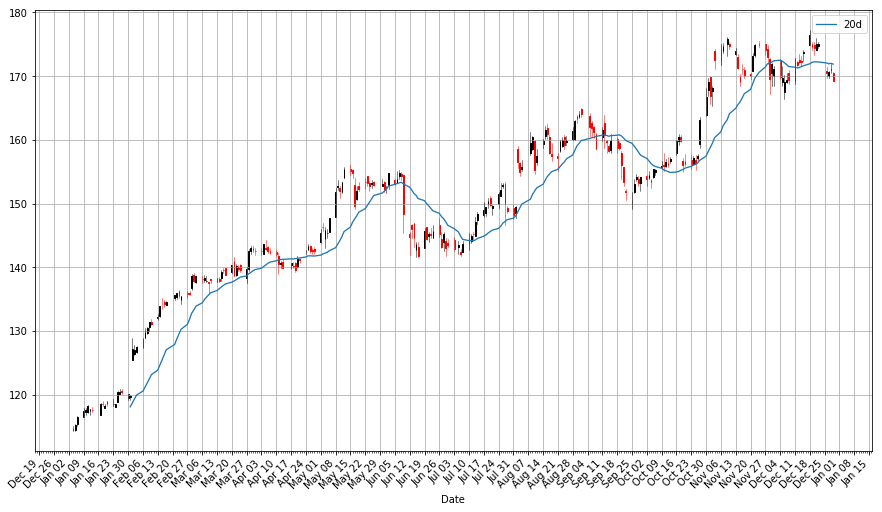

In [110]:
pandas_candlestick_ohlc(apple.loc['2017-01-04':'2017-12-31',:], otherseries = "20d", adj=True)

In [111]:
#Notice how late the rolling average begins
#It cannot be computed until 20 days have passed

In [112]:
#Because I would like to be able to compute 200-day moving averages, I'm going to extend out how much AAPL data we have. That said, we will still largely focus on 2016.

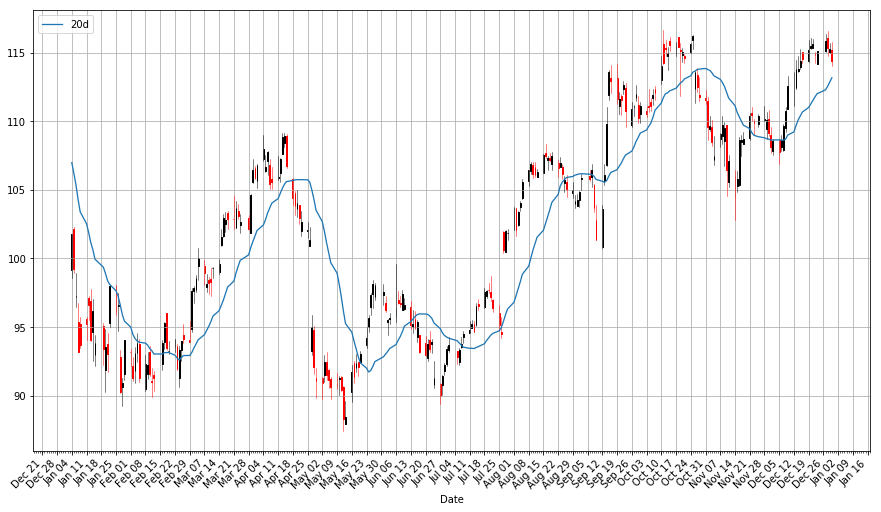

In [113]:
start = datetime.datetime(2010,1,1)
apple = quandl.get("WIKI/AAPL", start_date=start, end_date=end)
apple["20d"] = np.round(apple["Adj. Close"].rolling(window = 20, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-12-31',:], otherseries = "20d", adj=True)

In [114]:
#a moving average is much smoother than the actua stock data
#a stock needs to be above or below the moving average line in order for the line to change direction. 
#Thus, crossing a moving average signals a possible change in trend, and should draw attention.

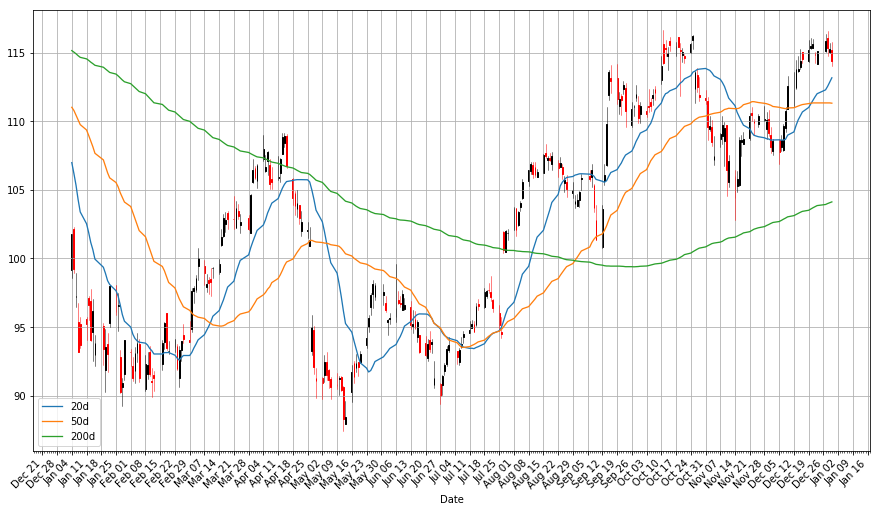

In [115]:
#It’s easy to examine multiple moving averages at once.

apple["50d"] = np.round(apple["Adj. Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Adj. Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-12-31',:], otherseries = ["20d", "50d", "200d"], adj=True)


In [116]:
#the crossing of moving average lines indicate changes in trend. 
#These crossings are what we can use as trading signals, 
#or indications that a financial security is changind direction and a profitable trade might be made.

In [117]:
#in any trade, a trader must have an exit strategy, a set of conditions determining when she will exit the position, for either profit or loss.
#A trader may set a target, which is the minimum profit that will induce the trader to leave the position. 
#Likewise, a trader may have a maximum loss she is willing to tolerate;

In [118]:
# a trader may decide that under no circumstances will she risk more than 10% of her portfolio on a trade.

In [119]:
#Here, I will be demonstrating a moving average crossover strategy. 
#We will use two moving averages, 
#one we consider “fast”, and the other “slow”. 
#The strategy is:

#Trade the asset when the fast moving average crosses over the slow moving average.
#Exit the trade when the fast moving average crosses over the slow moving average again.

In [120]:
#we should try to evaluate the quality of the strategy first. 
#The usual means for doing so is backtesting, 
#which is looking at how profitable the strategy is on historical data.

In [121]:
#Let’s see if we can automate the backtesting task.
#We first identify when the 20-day average is below the 50-day average, 
#and vice versa.

In [122]:
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,20d,50d,200d,20d-50d
Date,,,,,,,,,,,,,,,,
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0,176.94,172.57,162.68,4.37
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0,176.76,172.46,162.75,4.30
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0,176.23,172.27,162.81,3.96
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0,175.92,172.22,162.91,3.70
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0,175.41,172.05,162.98,3.36


In [124]:
#We will refer to the sign of this difference as the regime; 
#that is, if the fast moving average is ABOVE the slow moving average, this is a bullish regime (the bulls rule), 
#when the fast moving average is BELOW the slow moving average: a bearish regime (the bears rule) holds 

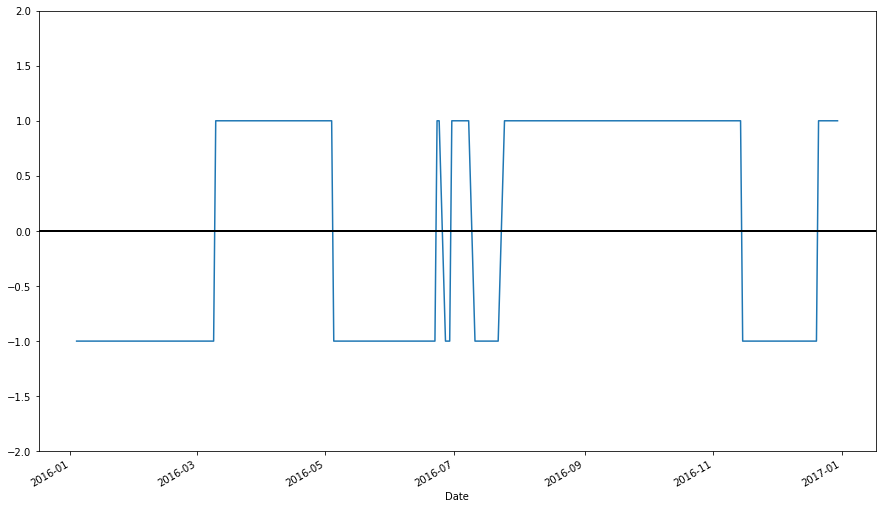

In [125]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc['2016-01-04':'2016-12-31',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

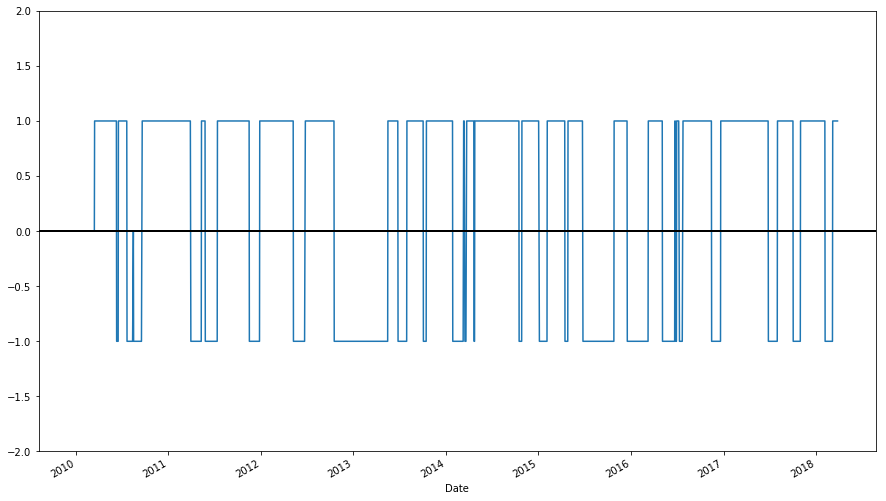

In [126]:
apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [127]:
apple["Regime"].value_counts()

 1    1323
-1     694
 0      53
Name: Regime, dtype: int64

In [129]:
#The last line above indicates that 
#[1] for 1323 days the market was bearish on Apple, 
#[-1] while for 695 days the market was bullish
#[0] and it was neutral for 54 days.

In [130]:
#if selling common stock
#When a bullish regime begins, a buy signal is triggered, 
#and when it ends, a sell signal is triggered.

#if shorting the stock or using stock option to bet against the market
#when a bearish regime begins, a sell signal is triggered, 
#and when the regime ends, a buy signal is triggered

In [132]:
#It's simple to obtain signals. 
#Let r_t indicate the regime at time t, and 
#s_t the signal at time t. 
#s_t = \text{sign}(r_t - r_{t - 1})
#s_t \in \{-1, 0, 1\}, 
#with -1 indicating "sell", 
#1 indicating "buy", 
#and 0 no action. 

In [133]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.loc[:, "Regime"].iloc[-1]
apple.loc[:, "Regime"].iloc[-1] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.loc[:, "Regime"].iloc[-1] = regime_orig
apple.tail()

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,20d,50d,200d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,,,,,,,
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0,176.94,172.57,162.68,4.37,1,0.0
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0,176.76,172.46,162.75,4.30,1,0.0
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0,176.23,172.27,162.81,3.96,1,0.0
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0,175.92,172.22,162.91,3.70,1,0.0
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0,175.41,172.05,162.98,3.36,1,-1.0


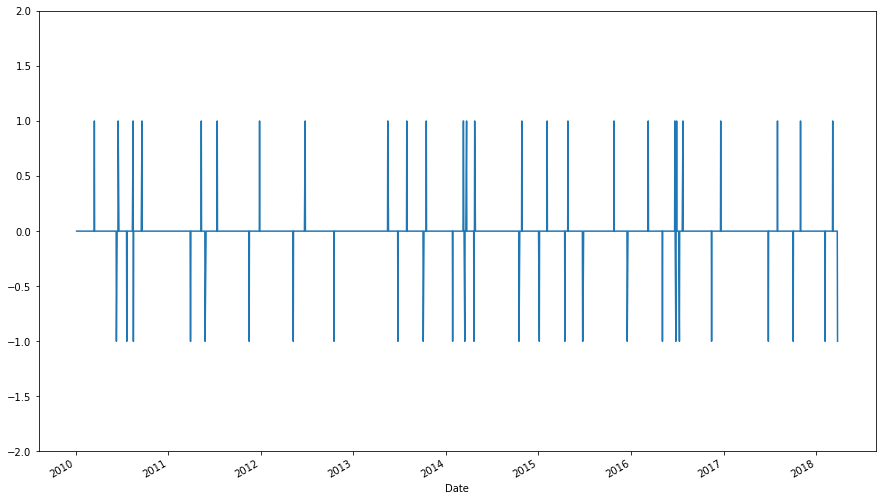

In [135]:
apple["Signal"].plot(ylim = (-2, 2))

In [137]:
apple["Signal"].value_counts()

 0.0    2014
-1.0      28
 1.0      27
Name: Signal, dtype: int64

In [139]:
# the system as it currently stands isn’t very robust
#A better system would require more evidence that the market is moving in some particular direction.

In [141]:
#identify what the price of the stock is at every buy
apple.loc[apple["Signal"] == 1, "Close"]

Date
2010-03-16    224.450
2010-06-18    274.074
2010-08-16    247.640
2010-09-20    283.230
2011-05-12    346.570
2011-07-14    357.770
2011-12-28    402.640
2012-06-25    570.765
2013-05-17    433.260
2013-07-31    452.530
2013-10-16    501.114
2014-03-11    536.090
2014-03-12    536.610
2014-03-24    539.190
2014-04-25    571.940
2014-10-28    106.740
2015-02-05    119.940
2015-04-28    130.560
2015-10-27    114.550
2016-03-10    101.170
2016-06-23     96.100
2016-06-30     95.600
2016-07-25     97.340
2016-12-21    117.060
2017-08-02    157.140
2017-11-01    166.890
2018-03-08    176.940
Name: Close, dtype: float64

In [143]:
#identify what the price of the stock is at every sell
apple.loc[apple["Signal"] == -1, "Close"]

Date
2010-06-11    253.5100
2010-07-22    259.0240
2010-08-17    251.9700
2011-03-30    348.6300
2011-03-31    348.5075
2011-05-27    337.4100
2011-11-17    377.4100
2012-05-09    569.1800
2012-10-17    644.6136
2013-06-26    398.0700
2013-10-04    483.0300
2014-01-28    506.5000
2014-03-17    526.7400
2014-04-22    531.6990
2014-10-17     97.6700
2015-01-05    106.2500
2015-04-16    126.1700
2015-06-25    127.5000
2015-06-26    126.7500
2015-12-18    106.0300
2016-05-05     93.2400
2016-06-27     92.0400
2016-07-11     96.9800
2016-11-15    107.1100
2017-06-27    143.7400
2017-10-03    154.4800
2018-02-06    163.0300
2018-03-27    168.3400
Name: Close, dtype: float64

In [144]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Adj. Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Adj. Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2010-03-16,28.844953,1,Buy
2010-06-11,32.579568,-1,Sell
2010-06-18,35.222329,1,Buy
2010-07-22,33.288194,-1,Sell
2010-08-16,31.825192,0,Buy
2010-08-17,32.381657,-1,Sell
2010-09-20,36.399003,1,Buy
2011-03-30,44.803814,0,Sell
2011-03-31,44.788071,-1,Sell


In [145]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

,Price,Profit,End Date
Date,,,
2010-03-16,28.844953,3.734615,2010-06-11
2010-06-18,35.222329,-1.934135,2010-07-22
2010-09-20,36.399003,8.404812,2011-03-30
2011-05-12,44.539075,-1.177188,2011-05-27
2011-07-14,45.978431,2.524014,2011-11-17
2011-12-28,51.744852,21.402711,2012-05-09
2012-06-25,73.351258,9.844240,2012-10-17
2013-05-17,56.878472,-4.619751,2013-06-26
2013-07-31,59.408242,4.423577,2013-10-04


In [148]:
#Let’s now create a simulated portfolio of $1,000,000, 
#and see how it would behave, according to the rules we have established. 
#This includes:

#Investing only 10% of the portfolio in any trade
#Exiting the position if losses exceed 20% of the value of the trade.

#When simulating, bear in mind that:


#Trades are done in batches of 100 stocks.
#Our stop-loss rule involves placing an order to sell the stock the moment the price drops below the specified level.

In [149]:
#Here’s how a backtest may look:

# We need to get the LOW of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_long_profits.index,
                            "End": apple_long_profits["End Date"]})
apple_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple.loc[x["Start"]:x["End"], "Adj. Low"]), axis = 1)
apple_long_profits

,Price,Profit,End Date,Low
Date,,,,
2010-03-16,28.844953,3.734615,2010-06-11,25.606402
2010-06-18,35.222329,-1.934135,2010-07-22,30.791939
2010-09-20,36.399003,8.404812,2011-03-30,35.341333
2011-05-12,44.539075,-1.177188,2011-05-27,42.335061
2011-07-14,45.978431,2.524014,2011-11-17,45.367990
2011-12-28,51.744852,21.402711,2012-05-09,51.471117
2012-06-25,73.351258,9.844240,2012-10-17,72.688768
2013-05-17,56.878472,-4.619751,2013-06-26,51.942335
2013-07-31,59.408242,4.423577,2013-10-04,59.001273


In [150]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits

cash = 1000000
apple_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .2    # % of trade loss that would trigger a stoploss
for index, row in apple_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest = apple_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)
 
apple_backtest

,Start Port. Value,End Port. Value,End Date,Shares,Share Price,Trade Value,Profit per Share,Total Profit,Stop-Loss Triggered
2010-03-16,1.000000e+06,1.012698e+06,2010-06-11,3400.0,28.844953,98072.841239,3.734615,12697.691096,0.0
2010-06-18,1.012698e+06,1.007282e+06,2010-07-22,2800.0,35.222329,98622.521053,-1.934135,-5415.577333,0.0
2010-09-20,1.007282e+06,1.029975e+06,2011-03-30,2700.0,36.399003,98277.306914,8.404812,22692.991110,0.0
2011-05-12,1.029975e+06,1.027268e+06,2011-05-27,2300.0,44.539075,102439.873355,-1.177188,-2707.531638,0.0
2011-07-14,1.027268e+06,1.032820e+06,2011-11-17,2200.0,45.978431,101152.549241,2.524014,5552.830218,0.0
2011-12-28,1.032820e+06,1.073486e+06,2012-05-09,1900.0,51.744852,98315.218526,21.402711,40665.151235,0.0
2012-06-25,1.073486e+06,1.087267e+06,2012-10-17,1400.0,73.351258,102691.760672,9.844240,13781.935982,0.0
2013-05-17,1.087267e+06,1.078490e+06,2013-06-26,1900.0,56.878472,108069.096937,-4.619751,-8777.527400,0.0
2013-07-31,1.078490e+06,1.086452e+06,2013-10-04,1800.0,59.408242,106934.835757,4.423577,7962.438409,0.0
2013-10-16,1.086452e+06,1.088218e+06,2014-01-28,1600.0,66.221597,105954.555657,1.103650,1765.839598,0.0


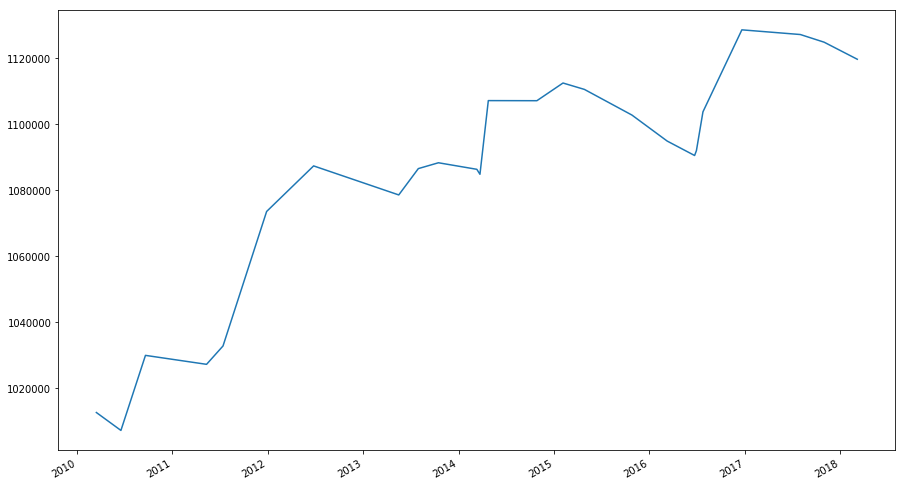

In [151]:
apple_backtest["End Port. Value"].plot()

In [152]:
#Backtesting is only part of evaluating the efficacy of a trading strategy. 
#We would like to benchmark the strategy, or compare it to other available (usually well-known) strategies 
#in order to determine how well we have done.

In [153]:
#Whenever you evaluate a trading system, 
#there is one strategy that you should always check, 
#one that beats all but a handful of managed mutual funds and investment managers: 
#buy and hold SPY. 

In [154]:
#Look at the profits for simply buying and holding SPY.

#spyder = web.DataReader("SPY", "yahoo", start, end)
spyder = spyderdat.loc[start:end]
spyder.iloc[[0,-1],:]

,Open,High,Low,Close,Adj Close
date,,,,,
2015-10-26,207.30,207.37,206.56,207.00,207.00
2018-10-25,267.38,271.81,266.23,270.08,270.08


In [155]:
batches = 1000000 // np.ceil(100 * spyder.loc[:,"Adj Close"].iloc[0]) # Maximum number of batches of stocks invested in
trade_val = batches * batch * spyder.loc[:,"Adj Close"].iloc[0] # How much money is used to buy SPY
final_val = batches * batch * spyder.loc[:,"Adj Close"].iloc[-1] + (1000000 - trade_val) # Final value of the portfolio
final_val

1302784.0

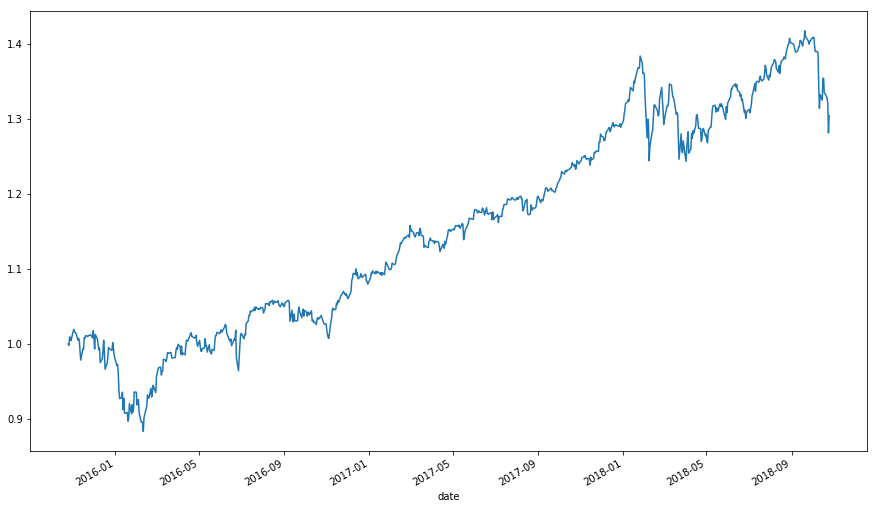

In [157]:
# We see that the buy-and-hold strategy beats the strategy we developed earlier. I would also like to see a plot.
ax_bench = (spyder["Adj Close"] / spyder.loc[:, "Adj Close"].iloc[0]).plot(label = "SPY")

In [158]:
#Other benchmark strategies exist, 
#and if our trading system beat the “buy and hold SPY” strategy, 
#We may check against them. 
#Some such strategies include:

#Buy SPY when its closing monthly price is aboves its ten-month moving average.
#Buy SPY when its ten-month momentum is positive. 
#(Momentum is the first difference of a moving average process,

In [159]:
#Does backtesting predict future performance? 
#Not at all. Backtesting has a propensity for overfitting, 
#so just because backtesting predicts high growth doesn’t mean that growth will hold in the future.

In [160]:
#strategies for combatting overfitting, 
#such as walk-forward analysis and holding out a portion of a dataset (likely the most recent part) as a final test set to determine if a strategy is profitable, 
#followed by “sitting on” a strategy that managed to survive these two filters and seeing if it remains profitable in current markets.